In [1]:
%load_ext autoreload
%autoreload 2

import sys
import math
import pickle
import random

import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pymesh

sys.path.append("../../")

import implicitmodules.torch as dm

In [2]:
source_boudin = dm.Utilities.generate_boudin(0.8, 0.5, 1., 0.3, 40, 20, 10)
source_boudin2 = dm.Utilities.generate_boudin(1., 0.3, 1.1, 0.4, 40, 20, 10)
#target_boudin = dm.Utilities.generate_boudin(0.75, 0.6, 0.8, 0.1, 40, 20, 10) #+ torch.tensor([0.15, 0.])
target_boudin = dm.Utilities.generate_boudin(0.75, 0.65, 1., 0.1, 40, 20, 10)+ torch.tensor([0.25, 0.])
target_boudin[:,0] = 1.3 * target_boudin[:,0]
target_boudin[:,1] = 0.8 * target_boudin[:, 1]

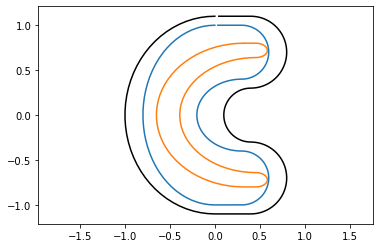

In [3]:
#%matplotlib qt5
plt.plot(source_boudin[:, 0].numpy(), source_boudin[:, 1].numpy())
plt.plot(source_boudin2[:, 0].numpy(), source_boudin2[:, 1].numpy(), 'k')
plt.plot(target_boudin[:, 0].numpy(), target_boudin[:, 1].numpy())
plt.axis('equal')
plt.show()

In [4]:
aabb = dm.Utilities.AABB.build_from_points(source_boudin2).scale(1.2)

implicit1_points = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb, 50., shape=source_boudin2)
implicit1_rot = dm.Utilities.rot2d(0.).repeat(implicit1_points.shape[0], 1, 1)

implicit1_c = torch.zeros(implicit1_points.shape[0], 2, 1)
implicit1_c[:, 0, 0] = 1.

angles = torch.zeros(implicit1_points.shape[0], requires_grad=True)

print(implicit1_points.shape)

torch.Size([148, 2])


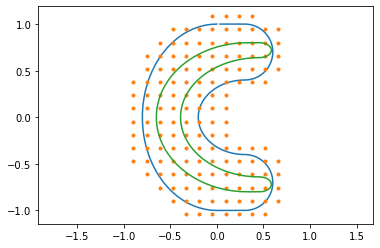

In [5]:
#%matplotlib qt5
plt.plot(source_boudin[:, 0].numpy(), source_boudin[:, 1].numpy())
plt.plot(implicit1_points[:, 0].numpy(), implicit1_points[:, 1].numpy(), '.')
plt.plot(target_boudin[:, 0].numpy(), target_boudin[:, 1].numpy())
plt.axis('equal')
plt.show()

In [6]:
sigma = 0.2

global_translation = dm.DeformationModules.GlobalTranslation(2)

implicit1 = dm.DeformationModules.ImplicitModule1(2, implicit1_points.shape[0], sigma, implicit1_c, nu=0.1, gd=(implicit1_points, implicit1_rot))

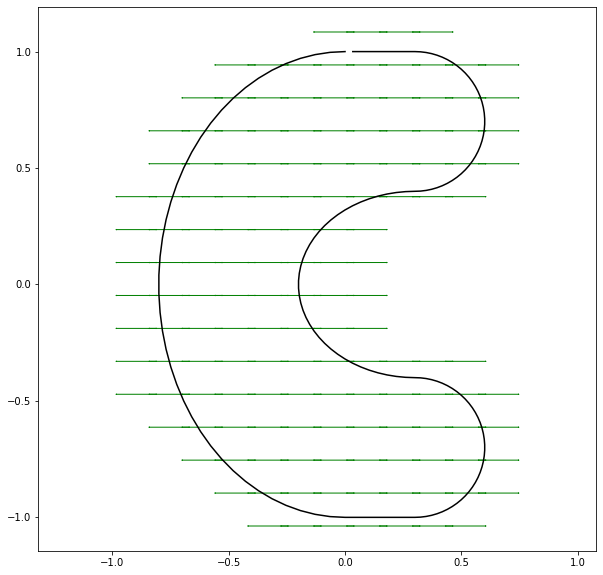

In [7]:
f = plt.figure(figsize=(10,10))
ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, implicit1_points, implicit1_c, R=dm.Utilities.rot2d_vec(torch.zeros(implicit1_points.shape[0])), c_index=0, color='green', scale=0.2)
plt.plot(source_boudin[:, 0].numpy(), source_boudin[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

In [8]:
source_deformable = dm.Models.DeformablePoints(source_boudin)
target_deformable = dm.Models.DeformablePoints(target_boudin)

def precompute(init_manifold, modules, parameters):
    rot = dm.Utilities.rot2d_vec(parameters['angles']['params'][0])

    init_manifold[2].gd = (init_manifold[2].gd[0], rot)


sigmas_varifold = [0.1, 1.]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

model = dm.Models.RegistrationModel([source_deformable], [global_translation, implicit1], [attachment], lam=500., precompute_callback=precompute, other_parameters={'angles': {'params': [angles]}})

In [9]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')

fitter.fit(target_deformable, 50, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(1625.5441)}
Time: 84.26426872299999
Iteration: 0
Costs
deformation=0.004806045442819595
attach=1401.3509521484375
Total cost=1401.3557581938803
Time: 98.89671752499999
Iteration: 1
Costs
deformation=0.004806045442819595
attach=1401.3519287109375
Total cost=1401.3567347563803
Optimisation process exited with message: Convergence achieved.
Final cost=1401.3567347563803
Model evaluation count=27
Time elapsed = 98.89723390599966


In [50]:
intermediates = {}
deformed = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0].detach()

In [51]:
basis = model.init_manifold[2].gd[1].detach()

In [52]:
def plot_2d_basis(points, basis, **kwords):
    plt.quiver(points[:, 0].numpy(), points[:, 1].numpy(), basis[:, 0, 0].numpy(), basis[:, 1, 0].numpy(), color='blue', headlength=0., headwidth=0., **kwords)
    plt.quiver(points[:, 0].numpy(), points[:, 1].numpy(), basis[:, 0, 1].numpy(), basis[:, 1, 1].numpy(), color='red', headlength=0.,headwidth=0., **kwords)


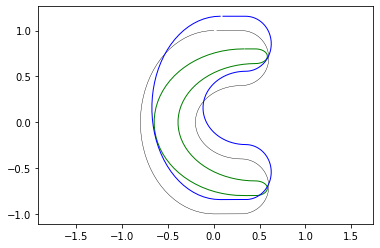

In [53]:
#%matplotlib qt5
plt.plot(source_boudin[:, 0].numpy(), source_boudin[:, 1].numpy(), lw=0.4, color='black')
plt.plot(target_boudin[:, 0].numpy(), target_boudin[:, 1].numpy(), lw=1., color='green')
plt.plot(deformed[:, 0].numpy(), deformed[:, 1].numpy(), lw=1., color='blue')
plt.axis('equal')
plt.show()

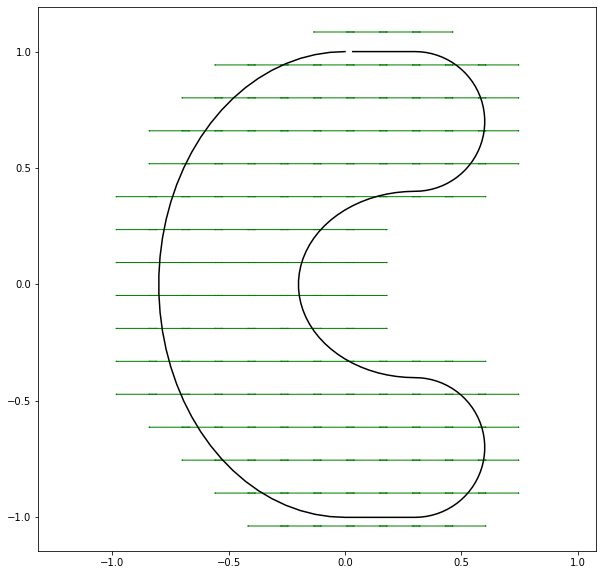

In [54]:
f = plt.figure(figsize=(10,10))
ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, implicit1_points, implicit1_c, R=basis.detach(), c_index=0, color='green', scale=0.2)
plt.plot(source_boudin[:, 0].numpy(), source_boudin[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

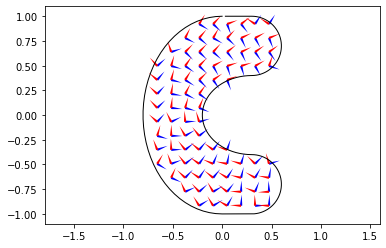

In [14]:
#%matplotlib qt5
plt.plot(source_boudin[:, 0].numpy(), source_boudin[:, 1].numpy(), lw=1., color='black')
plot_2d_basis(implicit1_points, basis, scale=30.)
plt.axis('equal')
plt.show()


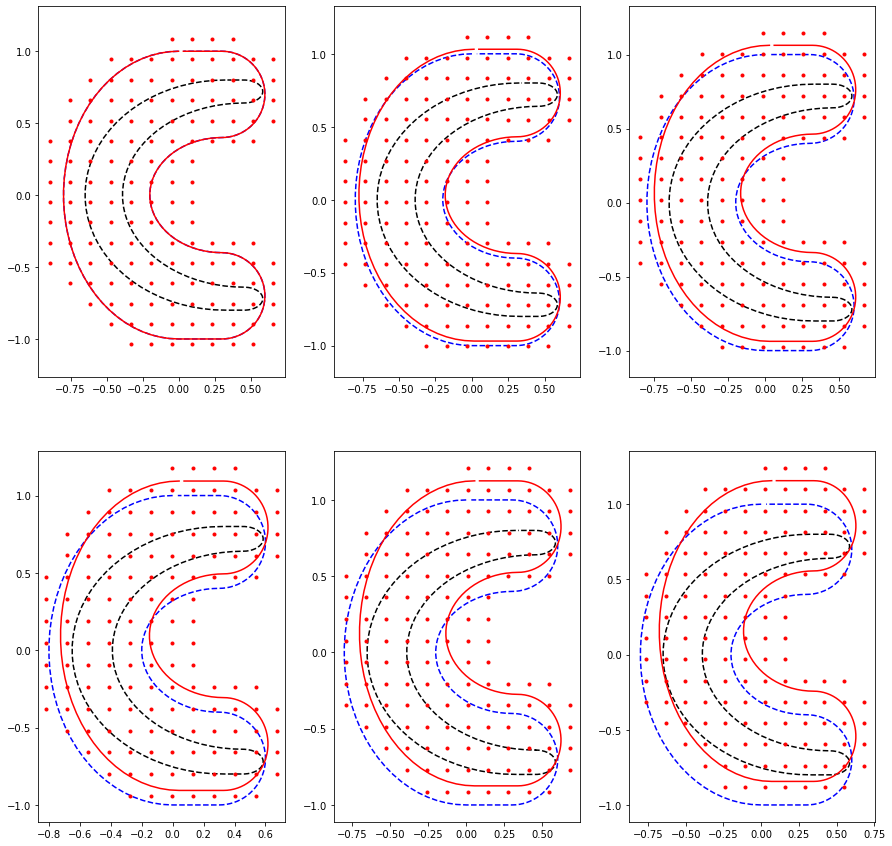

In [55]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    #if i<5:
    #    #print(intermediates['controls'][2*i][3])
    plt.plot(source_boudin.detach().numpy()[:,0], source_boudin.detach().numpy()[:,1], '--b')
    plt.plot(target_boudin.detach().numpy()[:,0], target_boudin.detach().numpy()[:,1], '--k')
    plt.plot(intermediates['states'][2*i].gd[0].detach().numpy()[:,0], intermediates['states'][2*i].gd[0].detach().numpy()[:,1], 'r')
    plt.plot(intermediates['states'][2*i].gd[2][0].detach().numpy()[:,0], intermediates['states'][2*i].gd[2][0].detach().numpy()[:,1], '.r')
    plt.axis('equal')